In [2]:
# NOTEBOOK SETTINGS
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))
display(HTML("<style>table {float:left}</style>"))
import warnings
warnings.filterwarnings('ignore')
import matplotlib
%matplotlib inline
%config Completer.use_jedi = False

<img src="Alpha Data.png" style="width: 300px;"/>

<center><b>ALPHA DATA<b/><center/>

# Store Segmentation 
#### By Guia, Fatih, and Leo

The objective is to create a healthier segmentation of the stores using clustering, as at the moment stores are simply categorized as either supermarket or hypermarket. The different charactersitics of the store clusters can then be analyzed and the client can decide in which type of store it is best to distribute their beer products.

### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pgeocode
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import mahalanobis
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.neighbors import NearestNeighbors

### Load and Merge Data From Database A

In [4]:
# MAIN SALES TABLE A

sales1 = pd.read_csv('./Dataset A/table_VENTAS_IMP_PART1.csv')
sales2 = pd.read_csv('./Dataset A/table_VENTAS_IMP_PART2 .csv')
sales = sales1.append(sales2, ignore_index=True)
sales['ID'] = range(len(sales)) # Create sales ID in the case that multiple promotions apply to the same product in the same week to later be able to group by each transaction

# IMPORT / MERGE DICTIONARY

store_codes = pd.read_excel('./Dataset A/Dictionary.xlsx', sheet_name='Stores', header=0)
week_codes = pd.read_excel('./Dataset A/Dictionary.xlsx', sheet_name='Time_Periods', header=0)
product_codes = pd.read_excel('./Dataset A/Dictionary.xlsx', sheet_name='Products', header=0)
province_codes = pd.read_excel('./Dataset A/Dictionary.xlsx', sheet_name='Provinces', header=0)
channel_codes = pd.read_excel('./Dataset A/Dictionary.xlsx', sheet_name='Channels', header=0)

# Adding Latitude and Longitude Info
nomi = pgeocode.Nominatim('es')

longitudes = []
latitudes = []
for code in store_codes['postal_code']:
    if len(str(code)) == 4:
        code = '0' + str(code)
    elif len(str(code)) == 3:
        code = str(code) + '00'
    longitudes.append(nomi.query_postal_code(str(code))['longitude'])
    latitudes.append(nomi.query_postal_code(str(code))['latitude'])
store_codes['longitude'] = longitudes
store_codes['latitude'] = latitudes
store_codes.loc[store_codes.postal_code==28000,'latitude'] = 40.4165
store_codes.loc[store_codes.postal_code==28000,'longitude'] = -3.7046

sales_df = sales.merge(store_codes, on=['cod_tienda'], how='left')
sales_df = sales_df.merge(week_codes, on=['cod_semana'], how='left')
sales_df = sales_df.merge(product_codes, on=['cod_producto'], how='left')
sales_df = sales_df.merge(province_codes, on=['cod_provincia'], how='left')
sales_df = sales_df.merge(channel_codes, on=['cod_canal'], how='left')


# IMPORT / MERGE PROMOTIONS

with open("./Dataset A/promotions_cleaned.csv", "w") as file:
    
    with open('./Dataset A/table_PROMOCIONES_IMP.csv', 'r') as promos:
        for line in promos.readlines()[1:]:
            line = line.replace('"','')
            line = line.replace('Promo','Promo ')
            line = line.replace(';','')
            file.write(line)

promotions = pd.read_csv('./Dataset A/promotions_cleaned.csv', sep=',', header=0, 
                         dtype={'cod_tienda':'object','cod_producto':'object'})
promotions = promotions[promotions['cod_tienda']!='expositor1']
promotions['cod_tienda'] = pd.to_numeric(promotions['cod_tienda'])
promotions['cod_producto'] = pd.to_numeric(promotions['cod_producto'])
promotions = promotions.dropna()
sales_df = sales_df.merge(promotions, on=['cod_tienda','cod_semana','cod_producto'], how='left')
sales_df['promocion'] = sales_df['promocion'].fillna('No Promo')


# IMPORT / MERGE PROJECTIONS

projections = pd.read_csv('./Dataset A/table_PROYECCIONES_IMP.csv', sep=';', header=1)
projections = projections.dropna()
sales_df = sales_df.merge(projections, on=['cod_tienda','cod_semana'], how='left')


# IMPORT / MERGE CLIMATE

climate = pd.read_csv('./Dataset A/table_CLIMA_IMP.csv', sep=';', header=0)
climate = climate.dropna()
for var in climate.columns[2:]:
    climate[var] = climate[var].str.replace(',','.')
    climate[var] = pd.to_numeric(climate[var])
sales_df = sales_df.merge(climate, on=['cod_semana','cod_provincia'], how='left')


# FORMATTING

sales_df = sales_df.sort_values('Date').reset_index(drop=True)
sales_df.columns = ['store_code','week_code','product_code','sales_units','sales_value','sales_volume','referencies',
                    'real_price_units','real_price_volume','rate_price_units','rate_price_volume','ID','channel_code',
                    'province_code','postal_code','sales_surface_sqmeters','longitude','latitude','date','period',
                    'category','segment','manufacturer','brand','packaging','volume','units','province','comunidad',
                    'canal','channel','promotion','extrapolation_factor','min_temp','max_temp','avg_temp','precipitation']

sales_df = sales_df.drop(['channel_code','province_code','canal','category', 'referencies'],1)


sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6483005 entries, 0 to 6483004
Data columns (total 32 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   store_code              int64         
 1   week_code               int64         
 2   product_code            int64         
 3   sales_units             int64         
 4   sales_value             float64       
 5   sales_volume            int64         
 6   real_price_units        float64       
 7   real_price_volume       float64       
 8   rate_price_units        float64       
 9   rate_price_volume       float64       
 10  ID                      int32         
 11  postal_code             int64         
 12  sales_surface_sqmeters  int64         
 13  longitude               float64       
 14  latitude                float64       
 15  date                    datetime64[ns]
 16  period                  object        
 17  segment                 object        
 18  ma

### Data Preprocessing

#### Removing Duplicates

By merging the promotions to the sales data, some duplicates were created as some stores had multiple promotions for the same product in the same week. For this clustering problem we do not need information on the type of promotion and are just interested in whether stores had a lot of promotions or not. Therefore, these duplicates are dropped to not infer with the rest of the data when doing aggregations.

In [5]:
sales_df2 = sales_df.drop_duplicates(subset=['store_code','week_code','product_code'])

print(f'Deleted {len(sales_df)-len(sales_df2)} duplicates.')

Deleted 224866 duplicates.


#### Handling Missing Values

The missing values for longitude and lattitude are caused by postal codes that do not exist in Spain. While some of the postal codes were cleaned to be in the right format and thus match, others simply do not exist in any shape or form. The weather data also has a lot of missing values all for the same weeks, which, however, can be dropped as later in feature engineering the different features are aggregated anyways and we still have a lot of data for each of the stores. Finally, the extrapolation factor is only relevant for time series forecasting, and can therefore be dropped completely.

In [6]:
sales_df2.isna().sum()

store_code                     0
week_code                      0
product_code                   0
sales_units                    0
sales_value                    0
sales_volume                   0
real_price_units               0
real_price_volume              0
rate_price_units               0
rate_price_volume              0
ID                             0
postal_code                    0
sales_surface_sqmeters         0
longitude                 180618
latitude                  180618
date                           0
period                         0
segment                        0
manufacturer                   0
brand                          0
packaging                      0
volume                         0
units                          0
province                       0
comunidad                      0
channel                        0
promotion                      0
extrapolation_factor         677
min_temp                   96804
max_temp                   96804
avg_temp  

<AxesSubplot:>

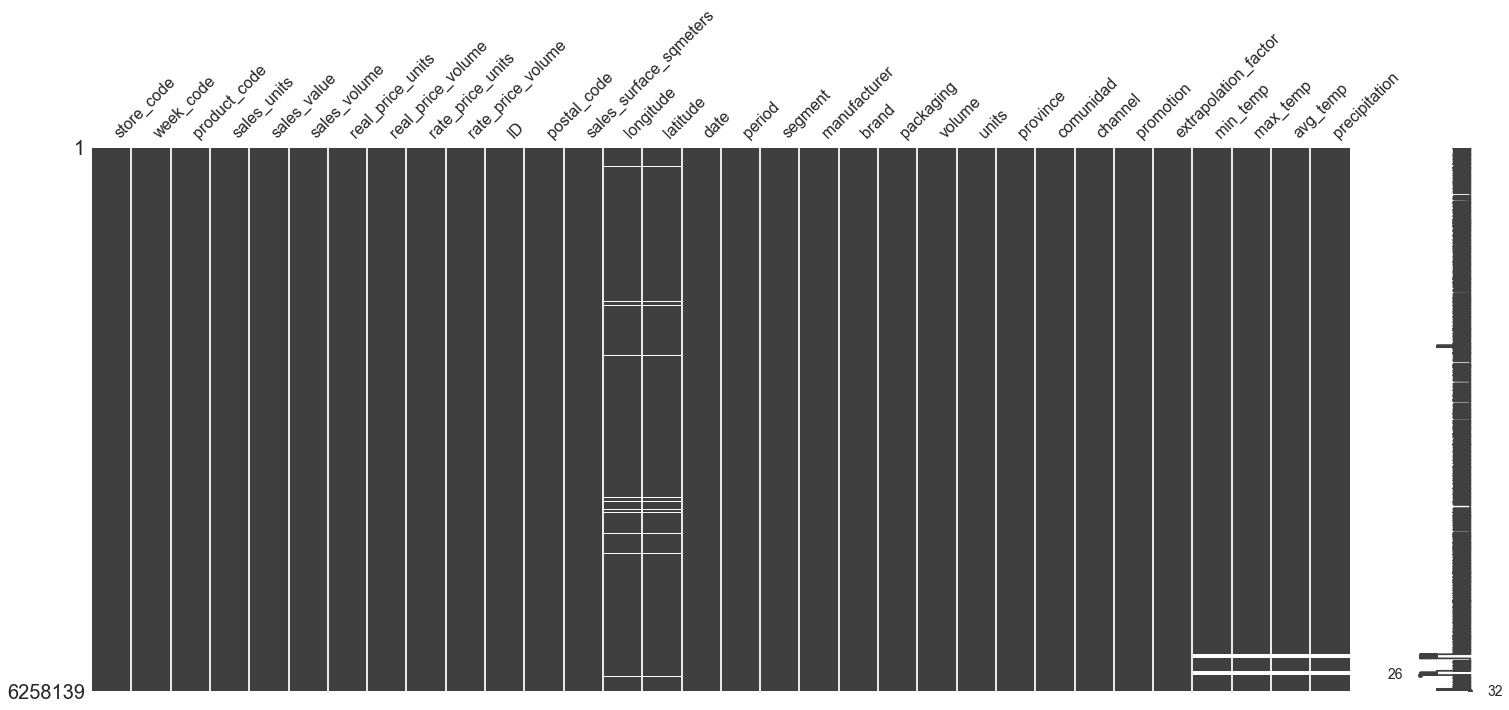

In [7]:
msno.matrix(sales_df2)

In [8]:
sales_df3 = sales_df2.drop('extrapolation_factor',1)
sales_df4 = sales_df2.dropna()

In [9]:
print('Missing values left:',sales_df4.isna().sum().sum())

Missing values left: 0


### Feature Engineering

In order to best segment the different stores the follwing features are created for each store from the data:
    
- `sales_surface_sqmeters`
    - To differentiate between different store sizes
    
    
- Percentage of products having `promotion`
    - To differentiate between normal and discount stores

    
- Percentage of imported beers sold (based on `segment`)
    - To differentiate stores by their product range
    
    
- Average weekly `sales_value`, `sales_units`, and `sales_volume` divided by `sales_surface_sqmeters`
    - To differentiate between successful and less successful stores (adjusted by the size of each)
    

<br>
Further, average avg_temp and precipitation of province store is located in where tested as features but introduced more noise than bringing value to the clusters. Also, latitude and longitude information for each store is obtained but these do not have much practical significance in clustering the stores so they will be used for visualizations in the EDA phase.
<br>
<br>

In [10]:
# Special aggregation functions
def promo_percent(x):
    return (len(x) - x[x=='No Promo'].count()) / len(x) 

def import_percent(x):
    count = x.value_counts()
    
    if 'IMPORT PREMIUM' in count.index:
        premium = count['IMPORT PREMIUM']
    else: premium = 0
    
    if 'IMPORT SPECIAL' in count.index:
        special = count['IMPORT SPECIAL']
    else: special = 0
        
    return (premium + special) / len(x)

def observations(x):
    return len(x)

# Aggregate features
sales_features = sales_df4.groupby(['store_code','week_code'], as_index=False).agg({
     'sales_value':'mean','sales_units':'mean','sales_volume':'mean'
 }).groupby('store_code', as_index=False).agg({
     'sales_value':'mean','sales_units':'mean','sales_volume':'mean'
 })

other_features = sales_df4.groupby(['store_code'], as_index=False).agg({
    'sales_surface_sqmeters':'mean', # Size of store in meters squared
    'promotion':promo_percent, # Percentage of products having promotions
    'segment':import_percent, # Percentage of imported beer sales
#     'avg_temp':'mean', # Average temperature of province store is located in
#     'precipitation':'mean', # Average precipitation of province store is located in
    'latitude':'mean', # latitude of store based on postal code
    'longitude':'mean', # Longitude of store based on postal code
    'ID':observations # Number of obeservations recorded
})

cluster_df = other_features.merge(sales_features, on='store_code')
cluster_df['value_adj'] = cluster_df.sales_value / cluster_df.sales_surface_sqmeters # Ratio sales value vs store size
cluster_df['units_adj'] = cluster_df.sales_units / cluster_df.sales_surface_sqmeters # Ratio sales units vs store size
cluster_df['volume_adj'] = cluster_df.sales_volume / cluster_df.sales_surface_sqmeters # Ratio sales volume vs store size

# Stores with less than 10 observations are dropped
cluster_df = cluster_df[cluster_df['ID'] > 10]

# Formatting
cluster_df = cluster_df.drop(['ID','sales_value','sales_units','sales_volume'],1)
cluster_df = cluster_df.set_index('store_code')
cluster_df.columns = ['surface_sqmeters','proportion_promotions','proportion_imported','latitude','longitude','value_adj','units_adj','volume_adj']

cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523 entries, 1 to 557
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_sqmeters       523 non-null    int64  
 1   proportion_promotions  523 non-null    float64
 2   proportion_imported    523 non-null    float64
 3   latitude               523 non-null    float64
 4   longitude              523 non-null    float64
 5   value_adj              523 non-null    float64
 6   units_adj              523 non-null    float64
 7   volume_adj             523 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 36.8 KB


In [11]:
cluster_df.head()

,surface_sqmeters,proportion_promotions,proportion_imported,latitude,longitude,value_adj,units_adj,volume_adj
store_code,,,,,,,,
1,500,0.181242,0.164766,36.8381,-2.4597,0.062012,0.134214,0.069644
3,1200,0.207236,0.181768,43.4647,-3.8044,0.013247,0.014401,0.007135
4,2200,0.357200,0.341412,43.2627,-2.9253,0.010446,0.007871,0.006271
5,900,0.244860,0.214393,39.8770,-0.0143,0.038493,0.093815,0.088882
6,200,0.137244,0.164256,41.2871,-4.6888,0.047742,0.088091,0.038022


### Exploratory Data Analysis

#### Store Size

Most stores seem to have a size of around 5000 m^2 or less. However, there are also a few stores which are much larger from 7500 to 12500 m^2.

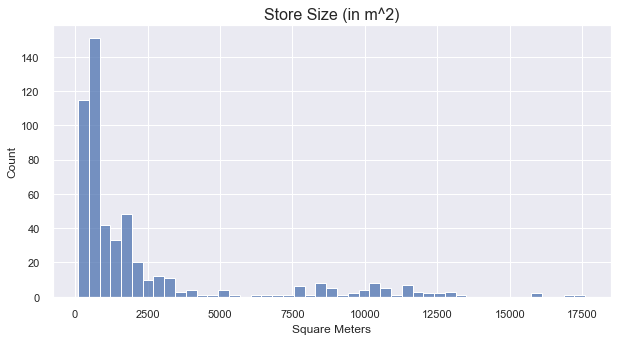

In [12]:
sns.set()
plt.subplots(figsize=(10,5))
sns.histplot(data=cluster_df, x='surface_sqmeters')
plt.title('Store Size (in m^2)', fontsize=16)
plt.xlabel('Square Meters');

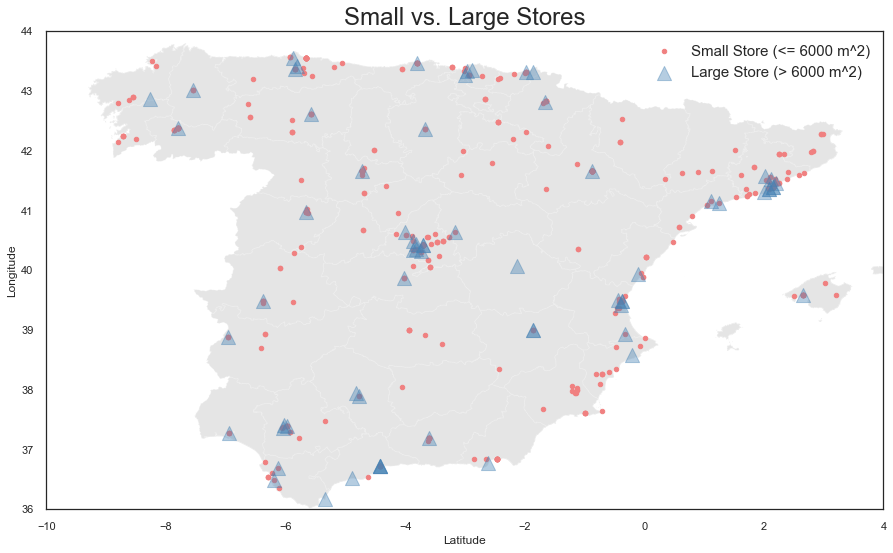

In [16]:
spain_map = gpd.read_file('spain_shapefile/natalidad.geojson')
geometry = [Point(xy) for xy in zip(cluster_df.longitude, cluster_df.latitude)]
geo_df = gpd.GeoDataFrame(cluster_df,crs={'init':'epsg:4326'},geometry=geometry)

sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,15))
ax.axis([-10, 4, 36, 44])
spain_map.plot(ax=ax, alpha=0.2, color='grey')
geo_df[geo_df['surface_sqmeters']<=6000].plot(ax=ax, markersize=20, color='lightcoral',marker='o',alpha=1,label='Small Store (<= 6000 m^2)')
geo_df[geo_df['surface_sqmeters']>6000].plot(ax=ax, markersize=200, color='steelblue',marker='^',alpha=0.4,label='Large Store (> 6000 m^2)')
plt.legend(prop={'size':15})
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Small vs. Large Stores',fontsize=24);

#### Proportion of Products with Promotions

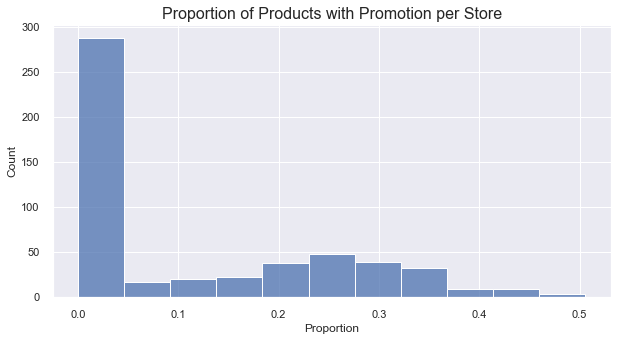

In [17]:
sns.set()
plt.subplots(figsize=(10,5))
sns.histplot(data=cluster_df, x='proportion_promotions')
plt.title('Proportion of Products with Promotion per Store', fontsize=16)
plt.xlabel('Proportion');

#### Proportion of Imported Beers

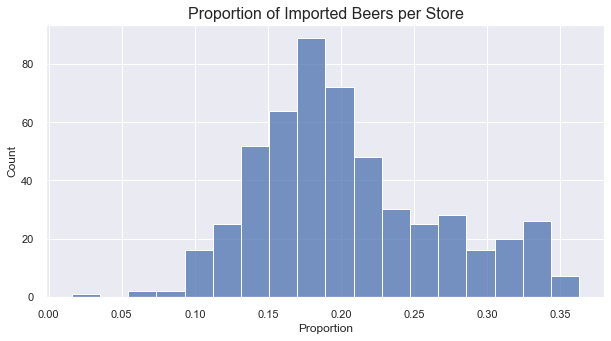

In [18]:
sns.set()
plt.subplots(figsize=(10,5))
sns.histplot(data=cluster_df, x='proportion_imported')
plt.title('Proportion of Imported Beers per Store', fontsize=16)
plt.xlabel('Proportion');

#### Relation between Proportion of Imported Beer Sales and Size of Store.

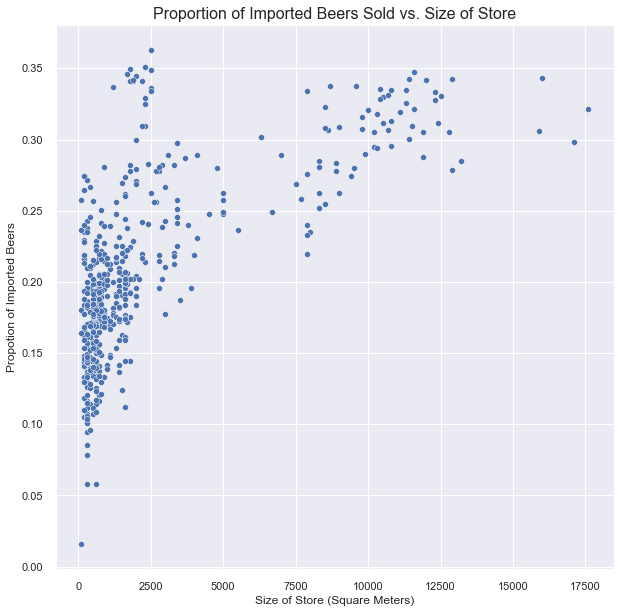

In [21]:
sns.set()
plt.subplots(figsize=(10,10))
sns.scatterplot(data=cluster_df, x='surface_sqmeters',y='proportion_imported');
plt.title('Proportion of Imported Beers Sold vs. Size of Store', fontsize=16)
plt.xlabel('Size of Store (Square Meters)')
plt.ylabel('Propotion of Imported Beers');

#### Correlations

Sales value, volume, and units are strongly correlated for obvious reasons, but in this case the decision to still keep all of them as the clustering seemed to work better with them included.

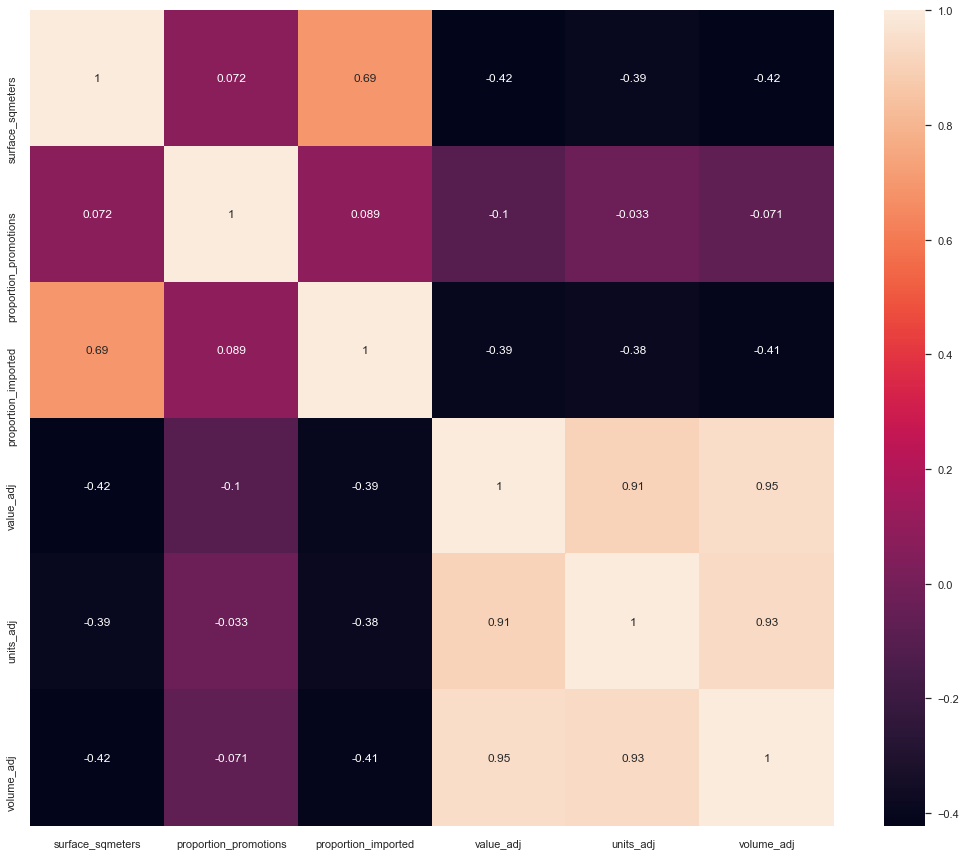

In [23]:
cluster_df_cor = cluster_df.drop(['longitude','latitude'],1).corr()

fig, ax = plt.subplots(figsize=(18,15))
sns.heatmap(cluster_df_cor, annot=True);

### Further Data Preprocessing

In [40]:
cluster_df2 = cluster_df.drop(['longitude','latitude','geometry'],1)

#### Univariate Outliers

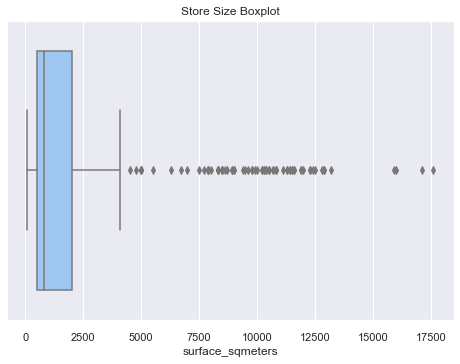

In [41]:
plt.style.use('seaborn-pastel')
sns.boxplot(cluster_df2.surface_sqmeters)
plt.title('Store Size Boxplot');

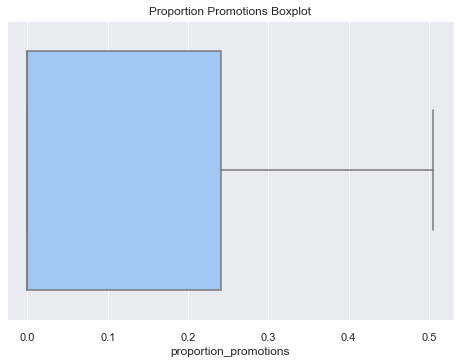

In [42]:
sns.boxplot(cluster_df2.proportion_promotions)
plt.title('Proportion Promotions Boxplot');

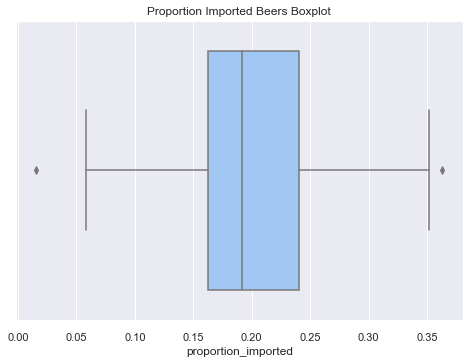

In [43]:
sns.boxplot(cluster_df2.proportion_imported)
plt.title('Proportion Imported Beers Boxplot');

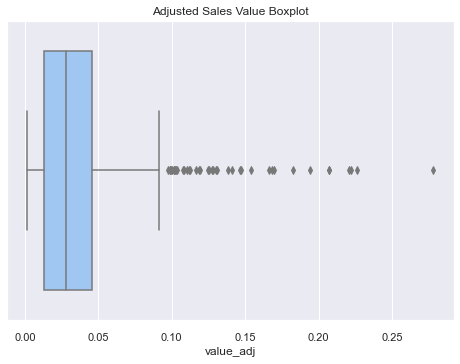

In [44]:
sns.boxplot(cluster_df2.value_adj)
plt.title('Adjusted Sales Value Boxplot');

**Multivariate Outliers**

Robust Mahalonobis Distance (Minimum Covariance Determinant Method)

In [45]:
def robust_mahalanobis_method(df):
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_
    robust_mean = cov.location_  
    inv_covmat = sp.linalg.inv(mcd) 
    
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier

multivariate_outliers = robust_mahalanobis_method(df=cluster_df2)

In [46]:
cluster_df2.iloc[multivariate_outliers,:]

,surface_sqmeters,proportion_promotions,proportion_imported,value_adj,units_adj,volume_adj
store_code,,,,,,
5,900,0.244860,0.214393,0.038493,0.093815,0.088882
20,100,0.200755,0.179987,0.278056,0.780229,0.306276
22,200,0.140156,0.183537,0.206900,0.265939,0.107745
43,17100,0.340076,0.298588,0.003600,0.003716,0.003267
81,100,0.126601,0.015825,0.168478,0.171948,0.114456
164,1200,0.246318,0.176993,0.037424,0.076425,0.080987
172,300,0.237280,0.181645,0.153797,0.346262,0.133332
174,100,0.163778,0.236113,0.182752,0.246311,0.104891
189,300,0.000000,0.128640,0.169822,0.293572,0.164146


In [47]:
cluster_df3 = cluster_df2.drop(cluster_df2.iloc[multivariate_outliers,:].index)

In this case, removing the multivariate outliers also took care of most of the extreme univariate outliers so no further processing is needed.

#### Scaling

In [48]:
scaler = StandardScaler()
scaler = scaler.fit(cluster_df3)
X = pd.DataFrame(scaler.transform(cluster_df3), columns=cluster_df3.columns)
X.head()

,surface_sqmeters,proportion_promotions,proportion_imported,value_adj,units_adj,volume_adj
0,-0.553639,0.491030,-0.641700,1.040820,1.869877,1.681887
1,-0.329711,0.676515,-0.366637,-0.742507,-0.711396,-0.869098
2,-0.009814,1.746627,2.216111,-0.844951,-0.852073,-0.904377
3,-0.649608,0.177071,-0.649936,0.518958,0.876197,0.391377
4,-0.553639,1.384835,-0.593985,-0.609348,-0.212166,-0.413416


## Clustering Approaches

Evaluation Metrics:
- Silhouette Score (-1 to 1, the closer to 1 the better)
    - Mean intra-cluster distance and mean nearest-cluster distance
- Calinski Harabasz Score (the higher the better)
    - Ratio between the within-cluster dispersion and the between-cluster dispersion
- Davies Buldin Score (the lower the better) 
    - Ratio of within-cluster distances to between-cluster distances

In [49]:
results = cluster_df3.copy(deep=True)
results_map = cluster_df.drop(cluster_df2.iloc[multivariate_outliers,:].index)

### Hierachical Clustering

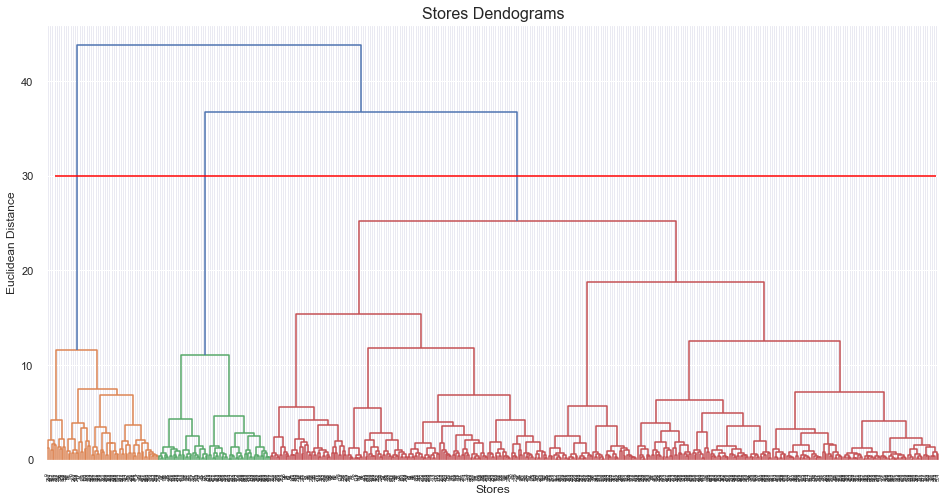

In [50]:
linked = linkage(X, 'ward')

sns.set()
plt.figure(figsize=(16, 8))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.hlines(30, xmin=50, xmax=5000, color='red')
plt.ylabel('Euclidean Distance')
plt.xlabel('Stores')
plt.title('Stores Dendograms', fontsize=16);

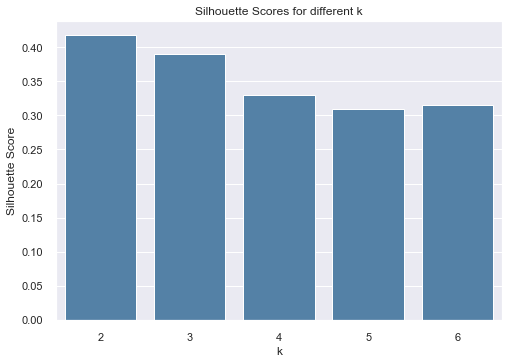

In [51]:
sil = []
for k in range(2,7):
    hc = AgglomerativeClustering(n_clusters = k, affinity='euclidean', linkage='ward').fit(X)
    sil.append(silhouette_score(X, hc.labels_, metric = 'euclidean'))
    
sil = pd.DataFrame({'k':range(2,7),'Silhouette Score':sil})

sns.barplot(data=sil, x='k', y='Silhouette Score', color='steelblue')
plt.title('Silhouette Scores for different k');

Even though 2 clusters have the highest silhouette score, from a business perspective it makes more sense to go with 3 clusters.

In [52]:
hierachical = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
results['hierachical_cluster'] = hierachical.fit_predict(X)
results_map['hierachical_cluster'] = results['hierachical_cluster']
results.head()

,surface_sqmeters,proportion_promotions,proportion_imported,value_adj,units_adj,volume_adj,hierachical_cluster
store_code,,,,,,,
1,500,0.181242,0.164766,0.062012,0.134214,0.069644,1
3,1200,0.207236,0.181768,0.013247,0.014401,0.007135,0
4,2200,0.357200,0.341412,0.010446,0.007871,0.006271,0
6,200,0.137244,0.164256,0.047742,0.088091,0.038022,0
7,500,0.306499,0.167715,0.016888,0.037573,0.018301,0


In [53]:
score = silhouette_score(X, hierachical.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.390


In [54]:
print('Calinski Harabasz Score: %.3f' % calinski_harabasz_score(X, hierachical.labels_))

Calinski Harabasz Score: 295.471


In [55]:
print('Davies Buldin Score: %.3f' % davies_bouldin_score(X, hierachical.labels_))

Davies Buldin Score: 0.821


### K-Means Clustering

#### Determining Optimal k

The Elbow method shows that the optimal k is most likely around 3 clusters. However, to be more exact when finding the best k, the silhouette plot for each is also plotted. This shows that k=3 also seems to be the best.

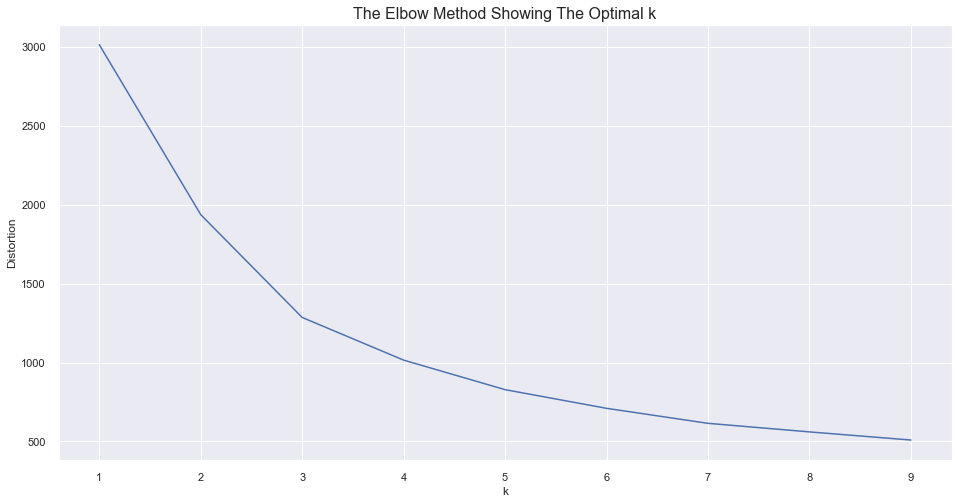

In [56]:
distortions = [] 
for k in range(1,10):
    kmean = KMeans(n_clusters=k, random_state=18)
    kmean.fit(X)
    distortions.append(kmean.inertia_)

sns.set()
plt.figure(figsize=(16,8))
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method Showing The Optimal k', fontsize=16)
plt.show()

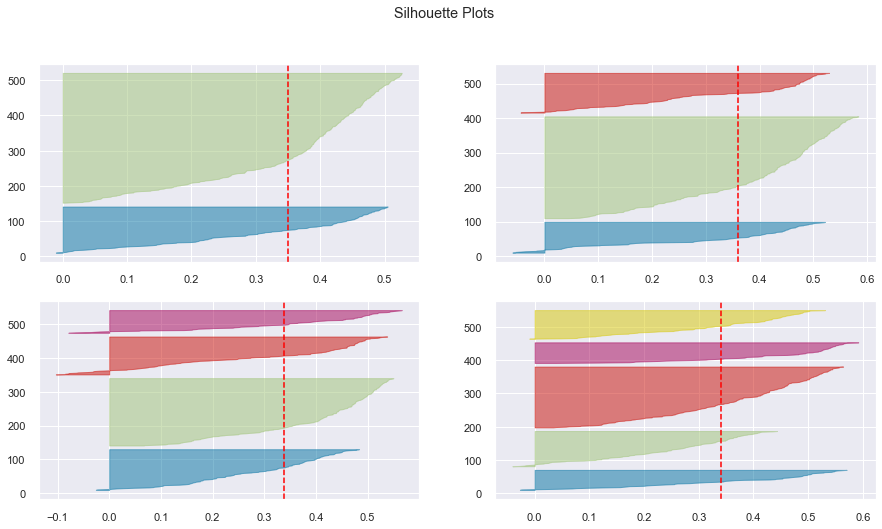

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range(2,6):

    km = KMeans(n_clusters=i, random_state=18)
    q, mod = divmod(i, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)


fig.suptitle('Silhouette Plots');

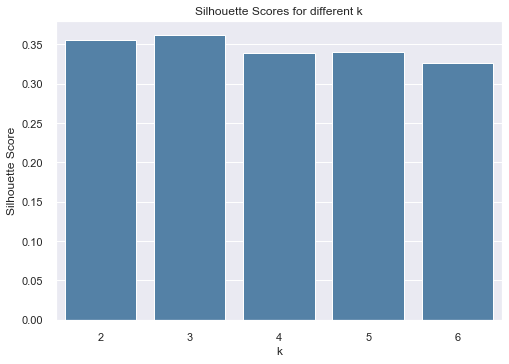

In [58]:
sil = []
for k in range(2,7):
    km = KMeans(n_clusters = k).fit(X)
    sil.append(silhouette_score(X, km.labels_, metric = 'euclidean'))
    
sil = pd.DataFrame({'k':range(2,7),'Silhouette Score':sil})

sns.barplot(data=sil, x='k', y='Silhouette Score', color='steelblue')
plt.title('Silhouette Scores for different k');

In [59]:
kmean = KMeans(n_clusters=3, random_state=18)
results['kmeans_cluster'] = kmean.fit_predict(X)
results.head()

,surface_sqmeters,proportion_promotions,proportion_imported,value_adj,units_adj,volume_adj,hierachical_cluster,kmeans_cluster
store_code,,,,,,,,
1,500,0.181242,0.164766,0.062012,0.134214,0.069644,1,0
3,1200,0.207236,0.181768,0.013247,0.014401,0.007135,0,1
4,2200,0.357200,0.341412,0.010446,0.007871,0.006271,0,2
6,200,0.137244,0.164256,0.047742,0.088091,0.038022,0,1
7,500,0.306499,0.167715,0.016888,0.037573,0.018301,0,1


In [60]:
score = silhouette_score(X, kmean.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.360


In [61]:
print('Calinski Harabasz Score: %.3f' % calinski_harabasz_score(X, kmean.labels_))

Calinski Harabasz Score: 335.204


In [62]:
print('Davies Bouldin Score: %.3f' % davies_bouldin_score(X, kmean.labels_))

Davies Bouldin Score: 1.026


#### Comparison in terms of internal validation between Hierachical and KMeans Clustering
The Silhouette Score for Hierachical Clustering is slightly higher, meaning that the clusters are better seperated on average when comparing distances between all points in one cluster and their average distance with the points in the closest different cluster. This is also confirmed by the Davies Bouldin Score, which is closer to 0 for Hierachical Clustering and similarly a measure of within and between cluster distances. However, the Calinski Harabasz Score is better for the KMEANS clusters, indicating, that the dispersion ratio between vs within those clusters is better.  

### DBSCAN

#### Hyperparameter Tuning: Epsilon and Min_Samples

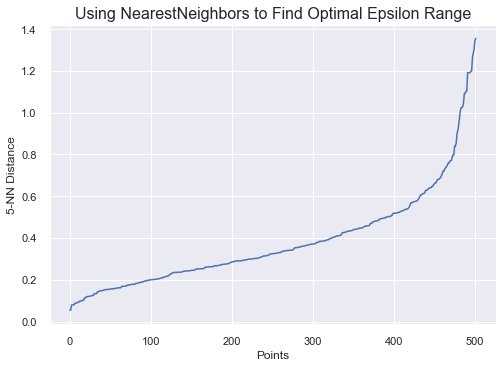

In [63]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

sns.set()
plt.xlabel('Points')
plt.ylabel('5-NN Distance')
plt.title('Using NearestNeighbors to Find Optimal Epsilon Range', fontsize=16)
plt.plot(distances);

The optimal Epsilon should be somewhere between 0.4 and 0.7. Optimally, this should be tuned using DBCV but was not able to find working Python implementation for this. Instead, the other three metrics were tested and the score adjusted to reach a reasonable number of clusters.

In [64]:
params_db = {
    'eps':np.arange(0.4,0.7,0.05),
    'min_samples':np.arange(3,10,1)
}

best_score = -1
best_eps = 0
best_min_samples = 0

for eps in params_db['eps']:
    for min_samples in params_db['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=8).fit(X)
        
        sil = davies_bouldin_score(X, dbscan.labels_)
        if sil > best_score:
            best_score = sil
            best_eps = eps
            best_min_samples = min_samples

print('eps:', best_eps)
print('min_samples:', best_min_samples)
print('score:', best_score)

eps: 0.5
min_samples: 8
score: 2.044043287499852


In [65]:
dbscan = DBSCAN(eps=0.64, min_samples=4, n_jobs=8)
results['dbscan_cluster'] = dbscan.fit_predict(X)

print('Number of clusters: %d' % (len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)))

Number of clusters: 3


In [66]:
results.head()

,surface_sqmeters,proportion_promotions,proportion_imported,value_adj,units_adj,volume_adj,hierachical_cluster,kmeans_cluster,dbscan_cluster
store_code,,,,,,,,,
1,500,0.181242,0.164766,0.062012,0.134214,0.069644,1,0,-1
3,1200,0.207236,0.181768,0.013247,0.014401,0.007135,0,1,0
4,2200,0.357200,0.341412,0.010446,0.007871,0.006271,0,2,0
6,200,0.137244,0.164256,0.047742,0.088091,0.038022,0,1,-1
7,500,0.306499,0.167715,0.016888,0.037573,0.018301,0,1,0


In [67]:
score = silhouette_score(X, dbscan.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

print('Calinski Harabasz Score: %.3f' % calinski_harabasz_score(X, dbscan.labels_))

print('Davies Bouldin Score: %.3f' % davies_bouldin_score(X, dbscan.labels_))

Silhouette Score: 0.245
Calinski Harabasz Score: 149.623
Davies Bouldin Score: 1.064


While these metrics are not optimal for DBSCAN, also looking at the resulting sizes of the clusters and how they are made up in the exploratory part below shows that DBSCAN is not the most suited for this problem.

### Exploring Hierarchical Clusters

In [68]:
h_cluster0 = results[results['hierachical_cluster']==0]
h_cluster1 = results[results['hierachical_cluster']==1]
h_cluster2 = results[results['hierachical_cluster']==2]

h_cluster_list = [h_cluster0, h_cluster1, h_cluster2]

h_overview = pd.DataFrame({
    #'Size of Cluster':[len(x) for x in h_cluster_list],
    'Mean Size of Store':[np.round(x.surface_sqmeters.mean(),2) for x in h_cluster_list],
    'Mean Proportion of Promotions':[np.round(x.proportion_promotions.mean(),2) for x in h_cluster_list],
    'Mean Proportion of Imported Beers':[np.round(x.proportion_imported.mean(),2) for x in h_cluster_list],
    'Mean Adj. Value':[np.round(x.value_adj.mean(),2) for x in h_cluster_list],
    'Mean Adj. Units':[np.round(x.units_adj.mean(),2) for x in h_cluster_list],
    'Mean Adj. Volume':[np.round(x.volume_adj.mean(),2) for x in h_cluster_list]
}, index=['Cluster 0','Cluster 1', 'Cluster 2'])

h_overview.T

,Cluster 0,Cluster 1,Cluster 2
Mean Size of Store,1248.94,361.90,9958.73
Mean Proportion of Promotions,0.11,0.07,0.14
Mean Proportion of Imported Beers,0.19,0.17,0.30
Mean Adj. Value,0.03,0.09,0.01
Mean Adj. Units,0.04,0.14,0.01
Mean Adj. Volume,0.02,0.08,0.00


#### The 3 Different Store Types
- Very small with little promotions, little imported beer sales, but high sales and units/volume sold compared to its size
- Medium size with more promotions, little imported beer sales, and medium sales value compared to its size
- Large stores with even more promotions and a higher proportion of sales of imported beers, but low sales compared to its size

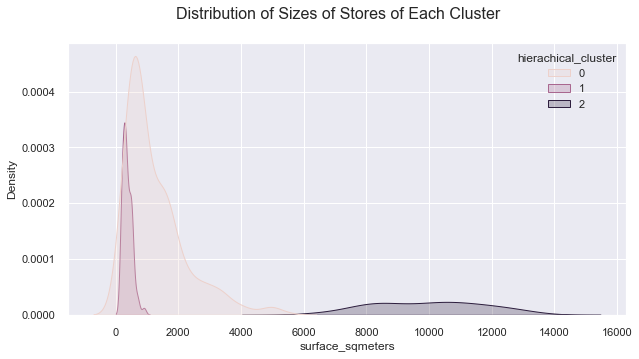

In [69]:
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(data=results, x='surface_sqmeters', hue='hierachical_cluster', fill=True)
fig.suptitle('Distribution of Sizes of Stores of Each Cluster', fontsize=16);

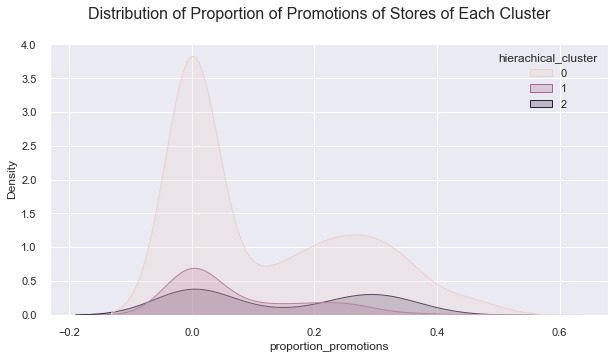

In [70]:
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(data=results, x='proportion_promotions', hue='hierachical_cluster', fill=True)
fig.suptitle('Distribution of Proportion of Promotions of Stores of Each Cluster', fontsize=16);

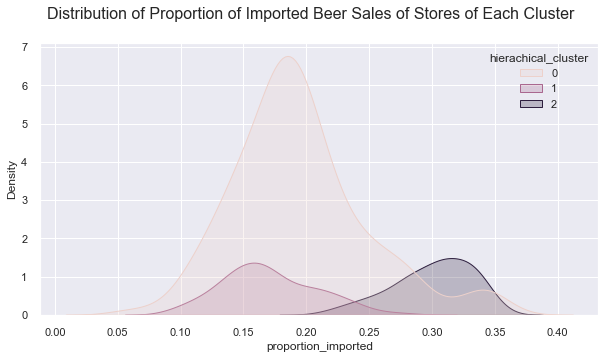

In [71]:
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(data=results, x='proportion_imported', hue='hierachical_cluster', fill=True)
fig.suptitle('Distribution of Proportion of Imported Beer Sales of Stores of Each Cluster', fontsize=16);

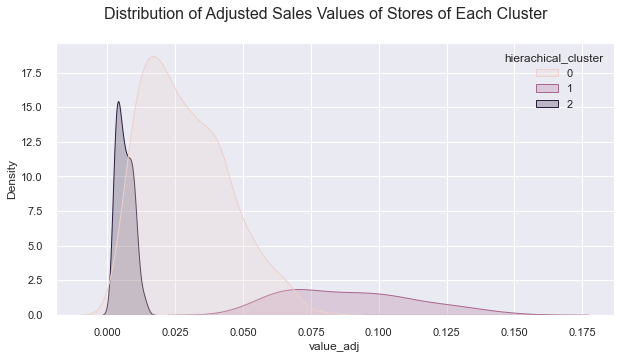

In [72]:
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(data=results, x='value_adj', hue='hierachical_cluster', fill=True)
fig.suptitle('Distribution of Adjusted Sales Values of Stores of Each Cluster', fontsize=16);

**CAUTION** These plots are not able to show all the different dimensions of the clusters but it is still interesting to see.

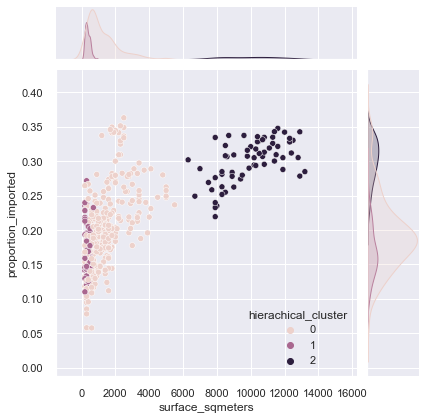

In [73]:
sns.jointplot(data=results,x='surface_sqmeters', y='proportion_imported', hue='hierachical_cluster');

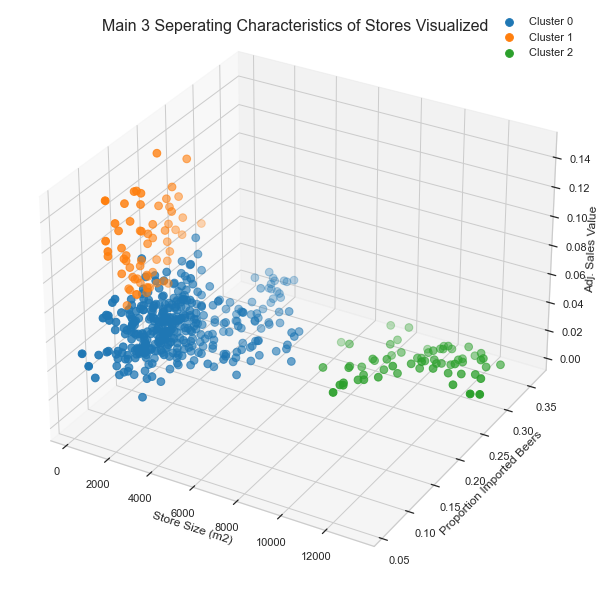

In [135]:
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)

ax.scatter(h_cluster0['surface_sqmeters'], h_cluster0['proportion_imported'], h_cluster0['value_adj'], s=60, marker='o', c='tab:blue', label='Cluster 0')
ax.scatter(h_cluster1['surface_sqmeters'], h_cluster1['proportion_imported'], h_cluster1['value_adj'], s=60, marker='o', c='tab:orange', label='Cluster 1')
ax.scatter(h_cluster2['surface_sqmeters'], h_cluster2['proportion_imported'], h_cluster2['value_adj'], s=60, marker='o', c='tab:green', label='Cluster 2')
ax.set_xlabel('Store Size (m2)')
ax.set_ylabel('Proportion Imported Beers')
ax.set_zlabel('Adj. Sales Value')
fig.suptitle('Main 3 Seperating Characteristics of Stores Visualized', fontsize=16)
plt.legend();

### Exploring KMeans Clusters

In [75]:
k_cluster0 = results[results['kmeans_cluster']==0]
k_cluster1 = results[results['kmeans_cluster']==1]
k_cluster2 = results[results['kmeans_cluster']==2]

k_cluster_list = [k_cluster0, k_cluster1, k_cluster2]

k_overview = pd.DataFrame({
    'Size of Cluster':[len(x) for x in k_cluster_list],
    'Mean Size of Store':[np.round(x.surface_sqmeters.mean(),2) for x in k_cluster_list],
    'Mean Proportion of Promotions':[np.round(x.proportion_promotions.mean(),2) for x in k_cluster_list],
    'Mean Proportion of Imported Beers':[np.round(x.proportion_imported.mean(),2) for x in k_cluster_list],
    'Mean Adj. Value':[np.round(x.value_adj.mean(),2) for x in k_cluster_list],
    'Mean Adj. Units':[np.round(x.units_adj.mean(),2) for x in k_cluster_list],
    'Mean Adj. Volume':[np.round(x.volume_adj.mean(),2) for x in k_cluster_list]
}, index=['Cluster 0','Cluster 1', 'Cluster 2'])

k_overview.T

,Cluster 0,Cluster 1,Cluster 2
Size of Cluster,90.00,296.00,116.00
Mean Size of Store,407.78,1018.58,6737.93
Mean Proportion of Promotions,0.09,0.11,0.13
Mean Proportion of Imported Beers,0.17,0.18,0.29
Mean Adj. Value,0.08,0.03,0.01
Mean Adj. Units,0.13,0.04,0.01
Mean Adj. Volume,0.07,0.02,0.01


Very similar to the hierarchical clusters just that more of the medium stores are also clustered with the large clusters as can be seen below. In this case the hierachical clustering algortihm has a higher Silhouette Score though.

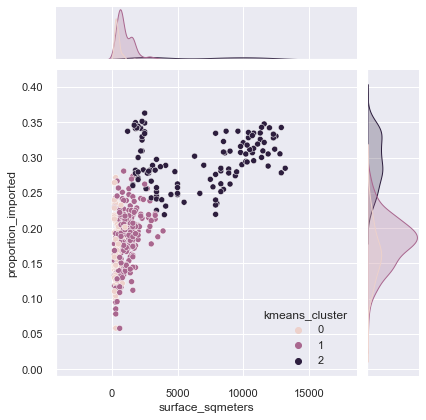

In [76]:
sns.jointplot(data=results,x='surface_sqmeters', y='proportion_imported', hue='kmeans_cluster');

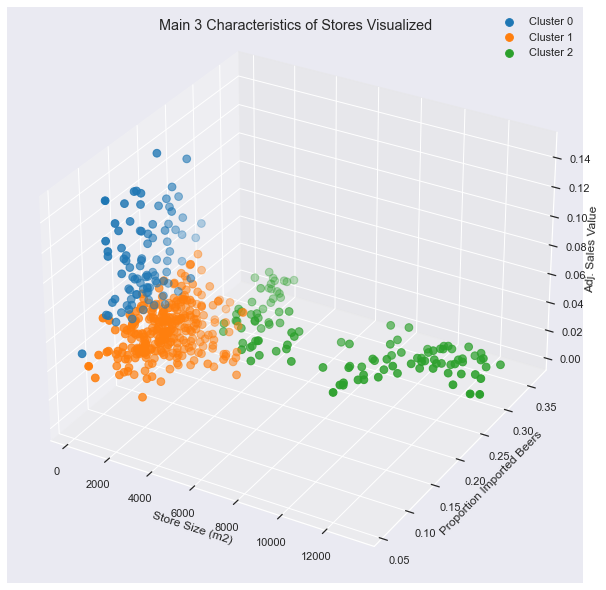

In [77]:
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)

ax.scatter(k_cluster0['surface_sqmeters'], k_cluster0['proportion_imported'], k_cluster0['value_adj'], s=60, marker='o', c='tab:blue', label='Cluster 0')
ax.scatter(k_cluster1['surface_sqmeters'], k_cluster1['proportion_imported'], k_cluster1['value_adj'], s=60, marker='o', c='tab:orange', label='Cluster 1')
ax.scatter(k_cluster2['surface_sqmeters'], k_cluster2['proportion_imported'], k_cluster2['value_adj'], s=60, marker='o', c='tab:green', label='Cluster 2')
ax.set_xlabel('Store Size (m2)')
ax.set_ylabel('Proportion Imported Beers')
ax.set_zlabel('Adj. Sales Value')
fig.suptitle('Main 3 Characteristics of Stores Visualized')
plt.legend();

### Exploring DBSCAN Clusters

In [78]:
d_cluster0 = results[results['dbscan_cluster']==0]
d_cluster1 = results[results['dbscan_cluster']==1]
d_cluster2 = results[results['dbscan_cluster']==2]

d_cluster_list = [d_cluster0, d_cluster1, d_cluster2]

d_overview = pd.DataFrame({
    'Size of Cluster':[len(x) for x in d_cluster_list],
    'Mean Size of Store':[np.round(x.surface_sqmeters.mean(),2) for x in d_cluster_list],
    'Mean Proportion of Promotions':[np.round(x.proportion_promotions.mean(),2) for x in d_cluster_list],
    'Mean Proportion of Imported Beers':[np.round(x.proportion_imported.mean(),2) for x in d_cluster_list],
    'Mean Adj. Value':[np.round(x.value_adj.mean(),2) for x in d_cluster_list],
    'Mean Adj. Units':[np.round(x.units_adj.mean(),2) for x in d_cluster_list],
    'Mean Adj. Volume':[np.round(x.volume_adj.mean(),2) for x in d_cluster_list]
}, index=['Cluster 0','Cluster 1', 'Cluster 2'])

d_overview.T

,Cluster 0,Cluster 1,Cluster 2
Size of Cluster,349.00,62.00,5.00
Mean Size of Store,1220.06,9979.03,800.00
Mean Proportion of Promotions,0.09,0.14,0.46
Mean Proportion of Imported Beers,0.19,0.30,0.20
Mean Adj. Value,0.03,0.01,0.04
Mean Adj. Units,0.04,0.01,0.06
Mean Adj. Volume,0.02,0.00,0.05


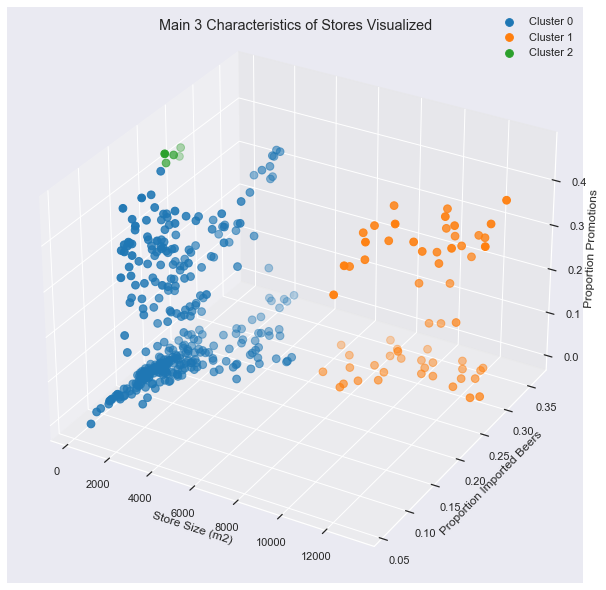

In [79]:
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)

ax.scatter(d_cluster0['surface_sqmeters'], d_cluster0['proportion_imported'], d_cluster0['proportion_promotions'], s=60, marker='o', c='tab:blue', label='Cluster 0')
ax.scatter(d_cluster1['surface_sqmeters'], d_cluster1['proportion_imported'], d_cluster1['proportion_promotions'], s=60, marker='o', c='tab:orange', label='Cluster 1')
ax.scatter(d_cluster2['surface_sqmeters'], d_cluster2['proportion_imported'], d_cluster2['proportion_promotions'], s=60, marker='o', c='tab:green', label='Cluster 2')
ax.set_xlabel('Store Size (m2)')
ax.set_ylabel('Proportion Imported Beers')
ax.set_zlabel('Proportion Promotions')
fig.suptitle('Main 3 Characteristics of Stores Visualized')
plt.legend();

### Mapping Stores based on their Hierachical Cluster

In [80]:
geometry2 = [Point(xy) for xy in zip(results_map.longitude, results_map.latitude)]
geo_df2 = gpd.GeoDataFrame(results_map,crs={'init':'epsg:4326'},geometry=geometry2)

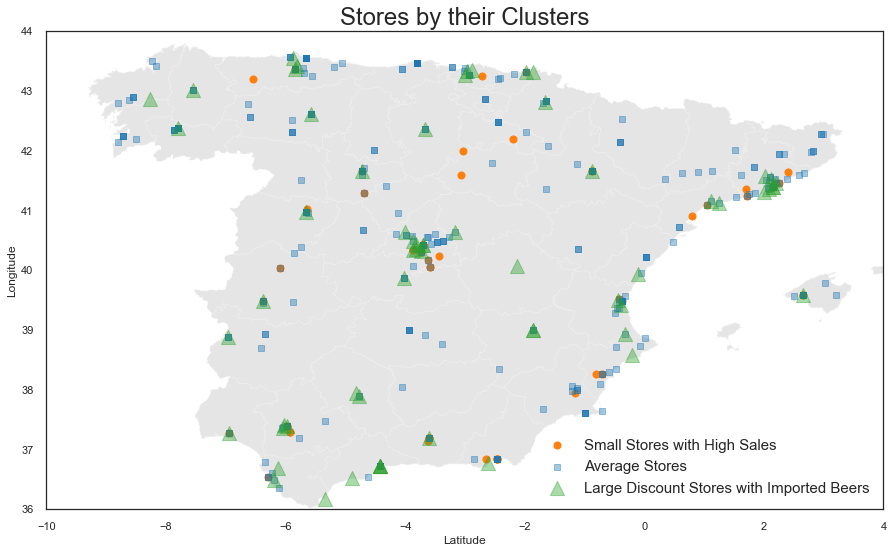

In [81]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,15))
ax.axis([-10, 4, 36, 44])
spain_map.plot(ax=ax, alpha=0.2, color='grey')
geo_df2[geo_df2['hierachical_cluster']==1].plot(ax=ax, markersize=50, color='tab:orange',marker='o',alpha=1,label='Small Stores with High Sales')
geo_df2[geo_df2['hierachical_cluster']==0].plot(ax=ax, markersize=40, color='tab:blue',marker='s',alpha=0.4,label='Average Stores')
geo_df2[geo_df2['hierachical_cluster']==2].plot(ax=ax, markersize=200, color='tab:green',marker='^',alpha=0.4,label='Large Discount Stores with Imported Beers')
plt.legend(prop={'size':15})
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Stores by their Clusters',fontsize=24);

## Conclusion
From the 3 clustering algortihms, Hierachical Clustering is chosen as the best method. Based on this, there are 3 main store types:
- Small Stores with little promotions and a smaller selection of imported beers but strong sales compared to their size. These are most likely stores located in densly populated areas such as cities, where there is not a lot of space but a lot of people coming to purchase beer (i.e. many can be seen in Madrid and Barcelona). This is where it would make sense to distributed some craft beers which are also more popular in the cities as we saw from earlier trends.
- Small and Medium Stores with a few more promotions but also not a lot imported beer sales and medium sales compared to their size. These can be thought of as the average regular supermarkets, which also make up the largest cluster. These are distributed all over Spain.
- Large discount stores with a high proportion in sales of imported beers, but low sales compared to their size. These come close to the category of hypermarkets that have more discounts and a wide selection of products. Interestingly, based on the map they are somewhat concentrated in Madrid and Barcelona as well, which makes sense as Imported Beers are most likely more popular there.

### Business Conclusions

#### Price Increases

Prices

In [123]:
rate_price0 = sales_df4[sales_df4.store_code.isin(h_cluster0.index)].groupby(sales_df4.date.dt.to_period('Y')).agg(AVG_RATE_PRICE=('rate_price_units','mean'))
print(f'The average rate price for normal stores increased by {np.round((rate_price0.AVG_RATE_PRICE[2] - rate_price0.AVG_RATE_PRICE[0]) * 100 / rate_price0.AVG_RATE_PRICE[0],2)} % from 2017 to 2019.')

The average rate price for normal stores increased by 5.75 % from 2017 to 2019.


In [124]:
rate_price1 = sales_df4[sales_df4.store_code.isin(h_cluster1.index)].groupby(sales_df4.date.dt.to_period('Y')).agg(AVG_RATE_PRICE=('rate_price_units','mean'))
print(f'The average rate price for small high-turnover stores increased by {np.round((rate_price1.AVG_RATE_PRICE[2] - rate_price1.AVG_RATE_PRICE[0]) * 100 / rate_price1.AVG_RATE_PRICE[0],2)} % from 2017 to 2019.')

The average rate price for small high-turnover stores increased by 2.93 % from 2017 to 2019.


In [125]:
rate_price2 = sales_df4[sales_df4.store_code.isin(h_cluster2.index)].groupby(sales_df4.date.dt.to_period('Y')).agg(AVG_RATE_PRICE=('rate_price_units','mean'))
print(f'The average rate price for large discount stores increased by {np.round((rate_price2.AVG_RATE_PRICE[2] - rate_price2.AVG_RATE_PRICE[0]) * 100 / rate_price2.AVG_RATE_PRICE[0],2)} % from 2017 to 2019.')

The average rate price for large discount stores increased by 5.87 % from 2017 to 2019.


Sales

In [209]:
rate_price0 = sales_df4[sales_df4.store_code.isin(h_cluster0.index)].groupby(sales_df4.date.dt.to_period('Y')).agg(SALES=('sales_value','sum'))
print(f'The sales of normal stores increased by {np.round((rate_price0.SALES[1] - rate_price0.SALES[0]) * 100 / rate_price0.SALES[0],2)} % from 2017 to 2018.')

The sales of normal stores increased by 4.82 % from 2017 to 2018.


In [201]:
rate_price0 = sales_df4[sales_df4.store_code.isin(h_cluster1.index)].groupby(sales_df4.date.dt.to_period('Y')).agg(SALES=('sales_value','sum'))
print(f'The sales of small stores increased by {np.round((rate_price0.SALES[1] - rate_price0.SALES[0]) * 100 / rate_price0.SALES[0],2)} % from 2017 to 2018.')

The sales of small stores increased by 1.77 % from 2017 to 2018.


In [202]:
rate_price0 = sales_df4[sales_df4.store_code.isin(h_cluster2.index)].groupby(sales_df4.date.dt.to_period('Y')).agg(SALES=('sales_value','sum'))
print(f'The sales of large stores increased by {np.round((rate_price0.SALES[1] - rate_price0.SALES[0]) * 100 / rate_price0.SALES[0],2)} % from 2017 to 2018.')

The sales of large stores increased by 3.45 % from 2017 to 2018.


#### Artisian Beers

In [199]:
rate_price0 = sales_df4[(sales_df4.store_code.isin(h_cluster0.index))&(sales_df4.segment=='ARTISANS')].groupby(sales_df4.date.dt.to_period('Y')).agg(SALES=('sales_value','sum'))
print(f'The sales of Artisan beers for normal stores increased by {np.round((rate_price0.SALES[1] - rate_price0.SALES[0]) * 100 / rate_price0.SALES[0],2)} % from 2017 to 2018.')

The sales of Artisan beers for normal stores increased by 14.19 % from 2017 to 2018.


In [151]:
rate_price0 = sales_df4[(sales_df4.store_code.isin(h_cluster1.index))&(sales_df4.segment=='ARTISANS')].groupby(sales_df4.date.dt.to_period('Y')).agg(SALES=('sales_value','sum'))
print(f'The sales of Artisan beers for small stores increased by {np.round((rate_price0.SALES[1] - rate_price0.SALES[0]) * 100 / rate_price0.SALES[0],2)} % from 2017 to 2018.')

The sales of Artisan beers for small stores increased by 8.86 % from 2017 to 2018.


In [149]:
rate_price0 = sales_df4[(sales_df4.store_code.isin(h_cluster2.index))&(sales_df4.segment=='ARTISANS')].groupby(sales_df4.date.dt.to_period('Y')).agg(SALES=('sales_value','sum'))
print(f'The sales of Artisan beers for large stores increased by {np.round((rate_price0.SALES[1] - rate_price0.SALES[0]) * 100 / rate_price0.SALES[0],2)} % from 2017 to 2018.')

The sales of Artisan beers for large stores increased by 40.94 % from 2017 to 2018.


#### Celiacs

In [178]:
rate_price0 = sales_df4[(sales_df4.store_code.isin(h_cluster0.index))&(sales_df4.segment=='CELIACS')].groupby(sales_df4.date.dt.to_period('Y')).agg(SALES=('sales_value','sum'))
print(f'The sales of Celiac beers for normal stores increased by {np.round((rate_price0.SALES[1] - rate_price0.SALES[0]) * 100 / rate_price0.SALES[0],2)} % from 2017 to 2018.')

The sales of Celiac beers for normal stores increased by 13.84 % from 2017 to 2018.


In [180]:
rate_price0 = sales_df4[(sales_df4.store_code.isin(h_cluster1.index))&(sales_df4.segment=='CELIACS')].groupby(sales_df4.date.dt.to_period('Y')).agg(SALES=('sales_value','sum'))
print(f'The sales of Celiac beers for small stores increased by {np.round((rate_price0.SALES[1] - rate_price0.SALES[0]) * 100 / rate_price0.SALES[0],2)} % from 2017 to 2018.')

The sales of Celiac beers for small stores increased by 65.57 % from 2017 to 2018.


In [174]:
rate_price0 = sales_df4[(sales_df4.store_code.isin(h_cluster2.index))&(sales_df4.segment=='CELIACS')].groupby(sales_df4.date.dt.to_period('Y')).agg(SALES=('sales_value','sum'))
print(f'The sales of Celiac beers for large stores increased by {np.round((rate_price0.SALES[1] - rate_price0.SALES[0]) * 100 / rate_price0.SALES[0],2)} % from 2017 to 2018.')

The sales of Celiac beers for large stores increased by -1.68 % from 2017 to 2018.


#### Percent Increase

In [291]:
inc = pd.DataFrame(columns=['segment','percent_increase'])
inc['segment'] = sales_df4.segment.unique()

ls = []
for i in inc['segment']:
    rate_price0 = sales_df4[sales_df4.segment==i].groupby(sales_df4.date.dt.to_period('Q')).agg(SALES=('sales_value','sum'))
    ls.append(np.round((rate_price0.SALES[8] - rate_price0.SALES[0]) * 100 / rate_price0.SALES[0],2))  
    
inc['percent_increase'] = ls
inc = inc.sort_values(by='percent_increase',ascending=False)

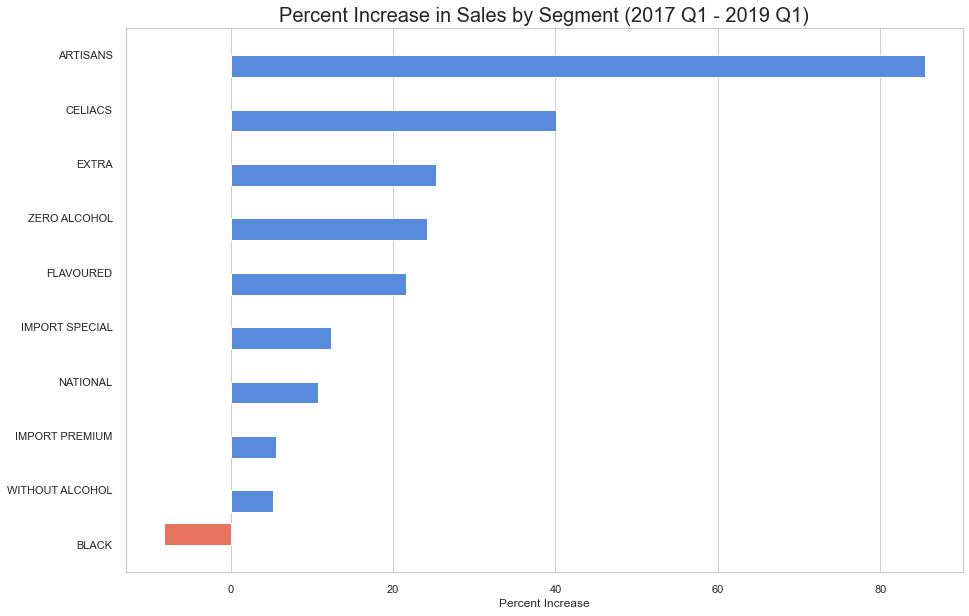

In [281]:
fig,ax=plt.subplots(figsize=(15,10))
sns.barplot(data=inc, y='segment', x='percent_increase',hue=[1 if i >= 0 else 0 for i in inc['percent_increase']], palette=['tomato','#4285f4'])
plt.legend([],[], frameon=False)
plt.ylabel('')
plt.xlabel('Percent Increase')
plt.title('Percent Increase in Sales by Segment (2017 Q1 - 2019 Q1)',fontsize=20);